![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import xgboost
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)


In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [5]:
# Celda 1
# Creación de variables por default
max_depth = None
num_pct = 10
max_features = None
min_gain=7000

# Definición de la función que calcula el SSE (Sum Squaered Error).
def SSE(y):
    if y.shape[0] == 0:
        return 0
    else:
        return ((y - y.mean())**2).sum()

# Definición de la función MSE_minimization para calular la ganancia de una variable predictora j dado el punto de corte k
def MSE_Minimization(X_col, y, split):
    
    filter_l = X_col <= split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    SSE_y = SSE(y)
    SSE_l = SSE(y_l)
    SSE_r = SSE(y_r)
    
    # Minimizing SSE
    SSE_min_ = SSE_l + SSE_r
    # We took the sqrt root just to made results easy to compare! It does not affect the algorithm.
    # Indeed this will make the algorithm to converge faster
    return np.sqrt(np.abs(SSE_y - SSE_min_))

# Definición de la función que obtiene el mejor split evaluando todas las variables

def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        # if splits.shape[0] == 1:
        #     splits = splits
        # elif splits.shape[0] > 1:
        #     splits = splits[1:]
        # else:
        #     splits = np.array([0]).astype(float)
        
        # Para cada partición
        for split in splits:
            gain = MSE_Minimization(X.iloc[:, j], y, split)
                        
            if gain >  best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=1000, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = y.mean() 
    
    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    # print(tree)
    # print(X_l.shape, y_l.shape, X_r.shape, y_r.shape)
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [6]:
tree = tree_grow(X, y, level=0, min_gain=7000, max_depth=max_depth, num_pct=10)
sample_tree =  {k: tree[k] for k in list(tree)[:6]}
sample_tree


{'y_pred': 14538.403716055265,
 'level': 0,
 'split': [0, 2012.0],
 'n_samples': 10495,
 'gain': 303719.8446066229,
 'sl': {'y_pred': 8773.392311255211,
  'level': 1,
  'split': [1, 97405.90909090909],
  'n_samples': 2159,
  'gain': 49344.21337563799,
  'sl': {'y_pred': 9937.111111111111,
   'level': 2,
   'split': [0, 2007.0],
   'n_samples': 981,
   'gain': 29621.724635160055,
   'sl': {'y_pred': 7874.037313432836,
    'level': 3,
    'split': -1,
    'n_samples': 134,
    'gain': 6029.0648340830485},
   'sr': {'y_pred': 10263.500590318772,
    'level': 3,
    'split': [0, 2009.0],
    'n_samples': 847,
    'gain': 19947.84966590238,
    'sl': {'y_pred': 9252.123287671233,
     'level': 4,
     'split': [1, 66836.45454545454],
     'n_samples': 219,
     'gain': 10368.380537327443,
     'sl': {'y_pred': 10392.666666666666,
      'level': 5,
      'split': [1, 40214.27272727273],
      'n_samples': 60,
      'gain': 7686.676146381114,
      'sl': {'y_pred': 12487.09090909091,
       '

In [7]:
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'
def tree_predict(X, tree):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        predicted = predicted * tree['y_pred']    
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])

    return predicted


In [8]:
def RMSE_Model(level=0, min_gain = 7000, max_depth= None, num_pct = 10):
    tree = tree_grow(X_train, y_train, level=level, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    y_pred = tree_predict(X_test, tree)
    
    return np.sqrt(np.mean(np.square(y_pred - y_test)))
print('El RMSE sobre el conjunto de Test es de:')
RMSE_Model()


El RMSE sobre el conjunto de Test es de:


1754.355121377251

In [9]:
def MAE_Model(level=0, min_gain = 7000, max_depth= None, num_pct = 10):
    tree = tree_grow(X_train, y_train, level=level, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    y_pred = tree_predict(X_test, tree)
    
    return np.mean(np.abs(y_pred - y_test))
print('El MAE sobre el conjunto de Test es de:')
MAE_Model()


El MAE sobre el conjunto de Test es de:


1307.5953681509916

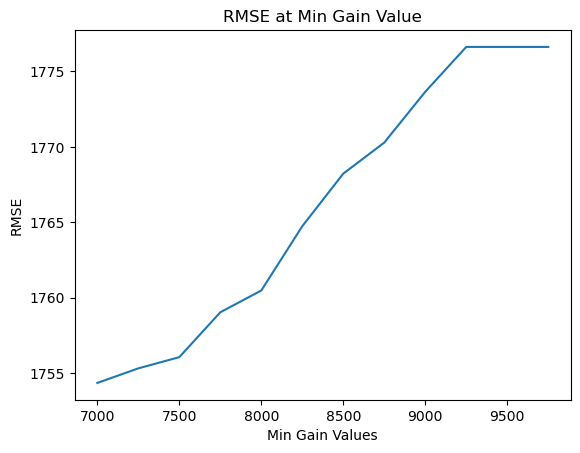

In [10]:
# Grafica modificando min gain
rango = np.arange(7000, 10000, 250)
values = [RMSE_Model(min_gain=j) for j in rango]
plt.plot(rango,values)
plt.xlabel('Min Gain Values')
plt.title('RMSE at Min Gain Value')
plt.ylabel('RMSE')
plt.show()


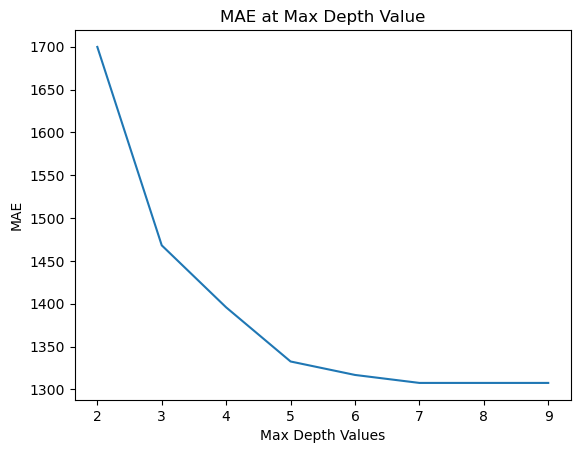

In [11]:
# Grafica modificando max depth
rango = np.arange(2, 10, 1)
values = [MAE_Model(max_depth=j) for j in rango]
plt.plot(rango,values)
plt.xlabel('Max Depth Values')
plt.title('MAE at Max Depth Value')
plt.ylabel('MAE')
plt.show()


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [12]:
# Celda 2
# We will use our own Trees

# Creación de 10 muestras de bootstrap 
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10
# 
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

level = 0
max_depth = None
num_pct = 10
min_gain=7000

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_trainBG = X_train.iloc[sample]
    y_trainBG = y_train.iloc[sample]
    treeBG = tree_grow(X_trainBG, y_trainBG, level=level, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    y_pred.iloc[:,i] = tree_predict(X_test, treeBG)
    
y_pred


,0,1,2,3,4,5,6,7,8,9
257343,13711.904580,12920.855072,13602.822660,13482.080569,12835.041284,13706.880240,12810.152047,13532.837209,13680.414449,13471.977528
326011,6337.154472,6580.487654,6332.266667,6485.329480,6303.866667,7598.701754,7862.612745,7557.204380,6239.875000,7856.953405
242354,16817.242105,16346.058574,15936.748000,16978.177388,16497.709505,16206.599775,16655.076208,16833.165333,16154.109649,16648.484429
266376,16104.822606,16346.058574,16039.288394,16225.698554,16497.709505,16206.599775,16073.866667,16100.910090,16154.109649,16065.386684
396954,16104.822606,16346.058574,16039.288394,16225.698554,16497.709505,16206.599775,16073.866667,16100.910090,16154.109649,16065.386684
...,...,...,...,...,...,...,...,...,...,...
144298,15837.267057,15855.876061,16059.420408,15967.887828,15964.986538,15842.101843,15980.320863,15945.922018,15875.097826,16022.562696
364521,16104.822606,16346.058574,16039.288394,16225.698554,15929.312187,16206.599775,16073.866667,16100.910090,16154.109649,16065.386684
120072,18214.878359,17797.127717,18087.583138,17905.815287,17959.649077,17720.516529,18755.032051,17832.261062,18175.964286,17829.904605
99878,12208.230769,12135.156379,12213.312500,13029.930435,11767.231183,12533.726619,11926.354369,12460.647059,12546.635135,12547.050000


In [13]:
for i in range(n_B):
    print('Árbol ', i, 'tiene un RMSE: ', np.sqrt(np.mean(np.square(np.array(y_pred.iloc[:,i]) - y_test))))
    

Árbol  0 tiene un RMSE:  1797.6092254393545
Árbol  1 tiene un RMSE:  1803.2259620254515
Árbol  2 tiene un RMSE:  1797.1101982748082
Árbol  3 tiene un RMSE:  1776.9360985322883
Árbol  4 tiene un RMSE:  1792.2384496068978
Árbol  5 tiene un RMSE:  1786.776635559031
Árbol  6 tiene un RMSE:  1787.1494109482162
Árbol  7 tiene un RMSE:  1760.7810838924463
Árbol  8 tiene un RMSE:  1776.8016434851907
Árbol  9 tiene un RMSE:  1766.19949120803


In [14]:
# Error al promediar las predicciones de todos los árboles
np.sqrt(np.mean(np.square(y_test - y_pred.mean(axis=1))))

1723.2912795541092


Interpretación de los RMSE individuales:

* Los RMSE de los primeros 10 árboles varían entre aproximadamente 1760 y 1803.
* El RMSE promedio de estos árboles es de alrededor de 1784.75, lo que sugiere una variabilidad moderada en la precisión de las predicciones entre los diferentes árboles.

Desempeño del modelo Bagging:

* Sabemos que el modelo Bagging combina las predicciones de los árboles para mejorar la precisión general y reducir el sobreajuste. En este caso, el RMSE del modelo Bagging es de 1723.29, que es considerablemente más bajo que el RMSE promedio de los árboles individuales. Este resultado indica que el ensamblaje (combinación de árboles) ha logrado reducir significativamente el error de predicción en comparación con cualquier árbol individual.

En resumen, los resultados indican que el modelo Bagging ha logrado mejorar el rendimiento en términos de RMSE en comparación con los árboles individuales en el ensamblaje. Esto demuestra la eficacia del ensamblaje en la reducción del error y resalta la importancia de evaluar el modelo final en datos independientes para una validación más sólida. Es de esperarse que después de ajustar hiperparámetros el desempeño del modelo sea aún mejor.


**Nota**: Aqui partimos de que se usó un hiperpárametro de mínima ganancia de 7000. De acuerdo a las gráficas más arriba es de esperarse que al disminuir dicho parámetro logremos una mejora significativa del modelo, solo que por rapidez en los tiempos de ejecución se ha dejado dicho valor.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [15]:
# Celda 3

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Configurar el modelo de bagging
n_features = X_train.shape[1]
max_features = int(np.log2(n_features))
bagging_model = BaggingRegressor(
    base_estimator=DecisionTreeRegressor(),
    n_estimators=10,
    max_features=max_features,
    random_state=42
)

# Entrenar el modelo
bagging_model.fit(X_train, y_train)

# Evaluar el desempeño del modelo
y_pred = bagging_model.predict(X_test)
score = r2_score(y_test, y_pred)

rmse_bg = np.sqrt(mean_squared_error(y_test, y_pred))
mae_bg = mean_absolute_error(y_test, y_pred)

print(f"El RMSE: {rmse_bg}")
print(f"El MAE: {mae_bg}")


El RMSE: 2274.1360002677716
El MAE: 1744.4522710146198


El modelo de bagging con libreria, que utiliza 10 árboles de regresión y configura el parámetro max_features basado en el logaritmo del número de características, logra un RMSE de 2274.136 indica que las predicciones del modelo de bagging para los precios de los automóviles se desvían, en promedio, aproximadamente 2274 del precio real. Este nivel de error sugiere que el modelo puede tener limitaciones al capturar todos los factores influyentes o que los precios de los automóviles varían ampliamente, haciendo más difícil lograr predicciones precisas. Por otro lado, el MAE de 1744.452 muestra que, en promedio, cada predicción se desvía por 1744 del valor actual, proporcionando una perspectiva del error típico en términos absolutos y sin considerar la dirección del error.

Estos valores de RMSE y MAE puede considerarse razonable dependiendo del rango de precios en el conjunto de datos, aunque también señala que hay espacio para mejorar la precisión del modelo.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [16]:
# Celda 4
from sklearn.ensemble import RandomForestRegressor
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenar el modelo
random_forest_model.fit(X_train, y_train)

# Evaluar el desempeño del modelo
y_pred = random_forest_model.predict(X_test)
score = r2_score(y_test, y_pred)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
mae_rf = mean_absolute_error(y_test, y_pred)

print(f"El RMSE: {rmse_rf}")
print(f"El MAE: {mae_rf}")


El RMSE: 1765.4118259983413
El MAE: 1314.4207078056425


El RMSE de 1765.411 sugiere que, en promedio, las predicciones del modelo tienen una desviación de aproximadamente $1765 del valor real de los precios. Este valor, aunque aún indica un error notable, es menor en comparación con el obtenido en el modelo de bagging, reflejando una mayor precisión en las predicciones del modelo de Random Forest. Este error menor puede indicar que el modelo está más capacitado para capturar la variabilidad y las relaciones subyacentes en el conjunto de datos de precios de automóviles.

Por otro lado, el MAE de 1314.421 refleja que el error medio absoluto de las predicciones es de alrededor de $1314. Este valor proporciona una visión más directa del error típico que se puede esperar de las predicciones del modelo, ignorando la dirección de los errores (sobrestimaciones o subestimaciones).

En conclusión, los valores de RMSE y MAE obtenidos con el modelo de Random Forest son indicativos de una capacidad razonablemente buena para predecir precios de automóviles, con un margen de error moderado. Estos resultados sugieren que el modelo de Random Forest es efectivo, aunque aún hay espacio para mejorar.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

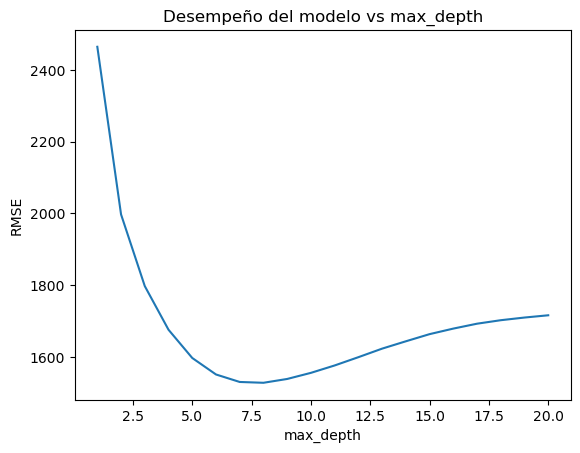

In [17]:
# Celda 5
from sklearn.model_selection import cross_val_score

# Creación de lista de valores para iterar sobre diferentes valores de max_depth
depth_range = range(1, 21)  #consideraremos profundidades de 1 a 20

# Definición de lista para almacenar el rmse promedio para cada valor de max_depth
rmse_scores_depth = []

# Uso de un 10-fold cross-validation para cada valor de max_depth
for depth in depth_range:
    rf = RandomForestRegressor(max_depth=depth, random_state=1, n_jobs=-1)
    rmse_scores_depth.append(-cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean())

# Gráfica del desempeño del modelo vs la profundidad máxima del árbol (max_depth)
plt.plot(depth_range, rmse_scores_depth)
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.title('Desempeño del modelo vs max_depth')
plt.show()


In [18]:
sorted(zip(rmse_scores_depth, depth_range))[0]

(1527.2405104850957, 8)

La gráfica nos indica que la profundidad máxima de cada árbol en el bosque debe ser de 8, dado que con esta profundidad se minimiza el RMSE. De esta manera se tiene un RMSE de 1527, así las predicciones del modelo podrían desviarse en promedio alrededor de 1527 unidades del valor real.

#### Calibración max_features

Text(0, 0.5, 'RMSE')

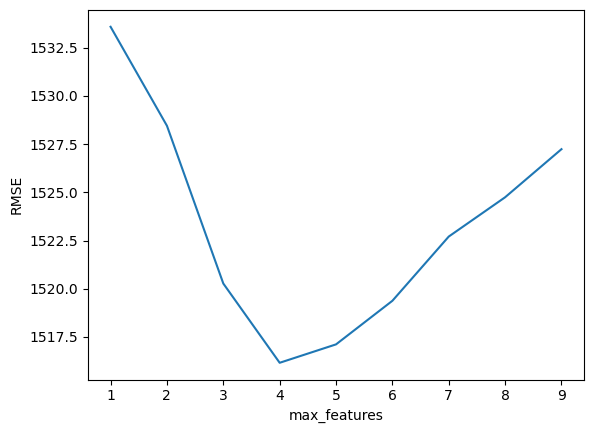

In [19]:
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, X_train.shape[1]+1)

# Definición de lista para almacenar el rmse promedio para cada valor de max_features
rmse_scores_f = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    rff = RandomForestRegressor( max_depth=8, max_features=feature, random_state=1, n_jobs=-1)
    rmse_scores_f.append(-cross_val_score(rff, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean())

# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, rmse_scores_f)
plt.xlabel('max_features')
plt.ylabel('RMSE')

In [20]:
sorted(zip(rmse_scores_f, feature_range))[0]

(1516.1577207089244, 4)

De acuerdo con la calibración, se tiene que el número máximo de características que se considerarán para dividir un nodo debe ser de 4 teniendo una profundidad de 8 de esta manera se tiene el menor RMSE. Es de mencionar que reducir el número máximo de características puede mejorar la generalización del modelo y reducir la varianza, con 4 características se presenta un RMSE de 1516.

#### Calibración de n_estimators

Text(0, 0.5, 'RMSE')

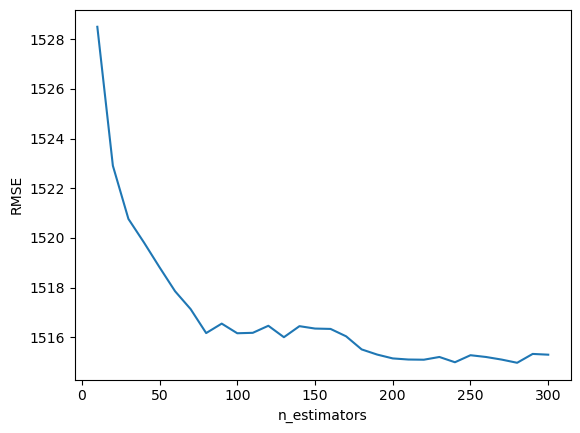

In [21]:
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 310, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
rmse_scores_n = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    rfn = RandomForestRegressor(max_depth=8, max_features=4, n_estimators=estimator, random_state=1, n_jobs=-1)
    rmse_scores_n.append(-cross_val_score(rfn, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean())
    
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, rmse_scores_n)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')

In [22]:
sorted(zip(rmse_scores_n, estimator_range))[0]

(1514.96846227286, 280)

Teniendo una profundidad de 8 y un número máximo de características de 4, se calibra el parámetro de la cantidad de árboles en el bosque, en donde se obtiene que con 280 se minimiza el RMSE a 1514. Así el RMSE sugiere que las predicciones del modelo podrían desviarse en promedio alrededor de 1514 unidades del valor real.

Es de mencionar que un mayor número de árboles puede mejorar la precisión del modelo, pero también aumenta el tiempo de entrenamiento, lo anterior descibe porque se seleccionaron 280 estimadores y no 200, ya que en la gráfica parece que tienen un RMSE similar.

#### Random Forest con parámetros calibrados

In [23]:
# Definición del modelo con los parámetros n_estimators=280, max_features=4,max_depth=8


rfc = RandomForestRegressor(n_estimators=280, max_features=4,max_depth=Se realiza el modelo de Random Forest con los parámetros calibrados, en donde la profundidad es de 8, el número de predictores de 4 y el número de estimadores es de 280. 

A partir de estos parámetros se obtiene un random forest con un RMSE de 1552. En este caso, significa que, en promedio, las predicciones del modelo están desviadas de los valores reales en aproximadamente 1552.13 dólares del precio del automóvil. 

Por otro lado, Un MAE de 1138.59 significa que, en promedio, las predicciones del modelo están desviadas de los valores reales en aproximadamente 1138.59 dólares del precio del automóvil., random_state=1, n_jobs=-1)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

rmse_rfc = np.sqrt(mean_squared_error(y_test, y_pred))
mae_rfc = mean_absolute_error(y_test, y_pred)

print("RMSE Random Forest con parámetros calibrados:", rmse_rfc)
print("MAE Random Forest con parámetros calibrados:", mae_rfc)

RMSE Random Forest con parámetros calibrados: 1552.1291620493587
MAE Random Forest con parámetros calibrados: 1138.5922723352235


Se realiza el modelo de Random Forest con los parámetros calibrados, en donde la profundidad es de 8, el número de predictores de 4 y el número de estimadores es de 280. 

A partir de estos parámetros se obtiene un random forest con un RMSE de 1552. En este caso, significa que, en promedio, las predicciones del modelo están desviadas de los valores reales en aproximadamente 1552.13 dólares del precio del automóvil. 

Por otro lado, Un MAE de 1138.59 significa que, en promedio, las predicciones del modelo están desviadas de los valores reales en aproximadamente 1138.59 dólares del precio del automóvil.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [24]:
# Celda 6
import xgboost
from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))
mae_xgb = mean_absolute_error(y_test, y_pred)

print("RMSE XGBoost:", rmse_xgb)
print("MAE XGBoost:", mae_xgb)


RMSE XGBoost: 1605.2355199928948
MAE XGBoost: 1185.2272991506386


Para el modelo XGBoost sin calibrar se presenta un RMSE de 1605.23, el cual sugiere que las predicciones del modelo podrían desviarse en promedio alrededor de 1605.23 unidades del precio real del automóvil. Mientras que el MAE es de 1185.23 significa que, en promedio, las predicciones del modelo están desviadas del precio real del automóvil en aproximadamente 1185.23 unidades de la misma escala que el precio.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [25]:
# Celda 7

from sklearn.model_selection import GridSearchCV

# Definir los parámetros a calibrar
parametros = {
    'learning_rate': [0.1, 0.01, 0.001],
    'gamma': [0, 0.1, 0.2, 0.3],
    'colsample_bytree': [0.5, 0.7, 0.9, 1]
}

# Crear el modelo XGBoost
xgb = XGBRegressor()

# Definir la búsqueda de parámetros
grid_search = GridSearchCV(estimator=xgb, param_grid=parametros, cv=5, n_jobs=-1)

# Realizar la búsqueda de parámetros
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo calibrado
xgb_mejorado = grid_search.best_estimator_

# Realizar predicciones con el mejor modelo
y_pred_mejorado = xgb_mejorado.predict(X_test)

# Calcular métricas de desempeño con el mejor modelo
rmse_xgb_mejorado = np.sqrt(mean_squared_error(y_test, y_pred_mejorado))
mae_xgb_mejorado = mean_absolute_error(y_test, y_pred_mejorado)

print("Mejores parámetros encontrados:", grid_search.best_params_)
print("RMSE XGBoost mejorado:", rmse_xgb_mejorado)
print("MAE XGBoost mejorado:", mae_xgb_mejorado)

Mejores parámetros encontrados: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1}
RMSE XGBoost mejorado: 1549.3205200247592
MAE XGBoost mejorado: 1138.295120204018


### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

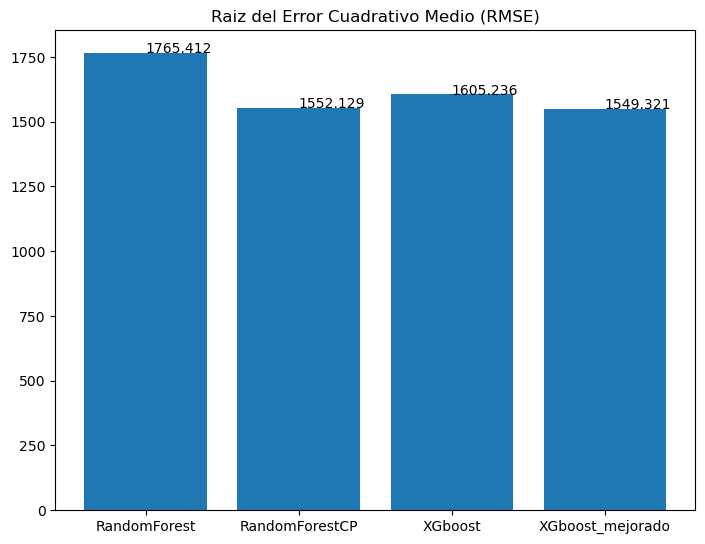

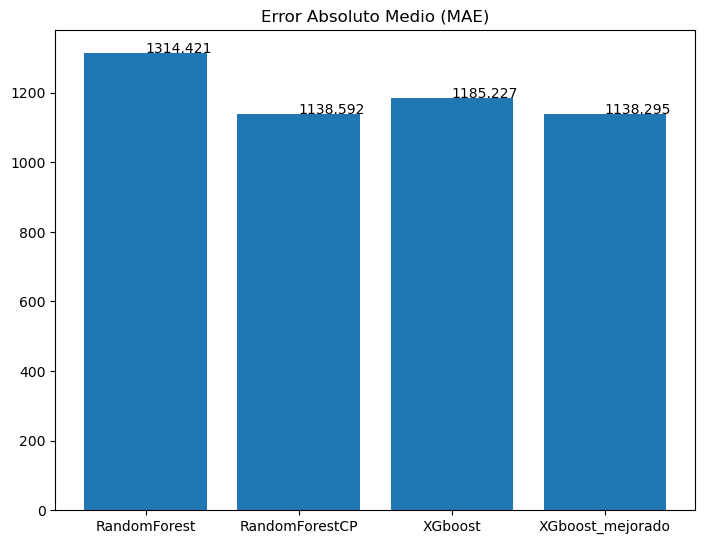

In [28]:
# Celda 8

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Raiz del Error Cuadrativo Medio (RMSE)")
ejeX = ['RandomForest', 'RandomForestCP','XGboost','XGboost_mejorado']
ejeY = [rmse_rf,rmse_rfc,rmse_xgb,rmse_xgb_mejorado]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],round(y[i],3))
addlabels(ejeX,ejeY,plt)
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Error Absoluto Medio (MAE)")
ejeX = ['RandomForest', 'RandomForestCP','XGboost','XGboost_mejorado']
ejeY = [mae_rf,mae_rfc,mae_xgb,mae_xgb_mejorado]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],round(y[i],3))
addlabels(ejeX,ejeY,plt)
plt.show()


El modelo de Random Forest original tiene el RMSE más alto con 1765.412, lo que indica que, en promedio, tiene la mayor desviación en las predicciones de precio respecto al valor real. El Random Forest con calibración de parametros muestra una mejora con un RMSE de 1552.129. Por otro lado, el XGBoost tiene un rendimiento similar al 'RandomForestCP' con un RMSE de 1605.236. El XGBoost con calibración de parametros tiene el RMSE más bajo con 1549.321, sugiriendo que este modelo tiene el mejor rendimiento en cuanto a la precisión de las predicciones.

En cuanto al MAE, el modelo de Random Forest original tiene el valor más alto con 1314.421, lo que refleja un mayor error medio en las predicciones. El Random Forest y XGBoost con calibración de parametros muestran mejoras significativas, ambos con valores de MAE muy similares de alrededor de 1138.5, lo que indica una precisión de predicción mejorada y errores más consistentes. La versión mejorada de XGBoost parece ofrecer una ligera ventaja en términos de MAE sobre la versión del Random Forest con parametros calibrados.

**Ventajas del Mejor Modelo:**

El XGBoost con parametros calibrados, teniendo el RMSE más bajo y un MAE competitivo, muestra ser el modelo más preciso. Esto sugiere que la optimización de hiperparámetros o la ingeniería de características realizada ha sido efectiva. Las ventajas incluyen:
- **Precisión**: Al tener el error promedio más bajo, es probable que las predicciones sean más cercanas al valor real, lo que es crítico en aplicaciones prácticas.
- **Consistencia**: Un MAE bajo implica que el modelo comete errores consistentemente menores, lo cual es importante para mantener la confiabilidad en las predicciones.


**Desventajas del Modelo con Menor Desempeño:**

El Random Forest original, con el RMSE y MAE más altos, parece ser el menos adecuado para la tarea de predicción de precios de automóviles. Sus desventajas podrían ser:
- **Precisión general**: Un RMSE alto indica una precisión baja en general, lo cual puede ser un problema si se busca usar el modelo para establecer precios o para sistemas de recomendación.
- **Error medio**: Un MAE alto sugiere que el modelo puede no ser tan confiable en la estimación de precios, lo cual podría llevar a decisiones basadas en información incorrecta.


En conclusión, mientras que el XGBoost mejorado parece ser el modelo más prometedor con la precisión más alta y errores menores en promedio, el Random Forest original podría requerir una revisión de características, un ajuste de hiperparámetros, o una estrategia de modelado diferente para mejorar su rendimiento como se hizo a traves del RAndome Forest con calibración de aprametros. De igual modo, el modo mas consistente seguia siendo el XGBoost.